In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model


In [4]:
data = pd.read_csv('/kaggle/input/fer2013/fer2013.csv')

In [5]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
data['Usage'].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

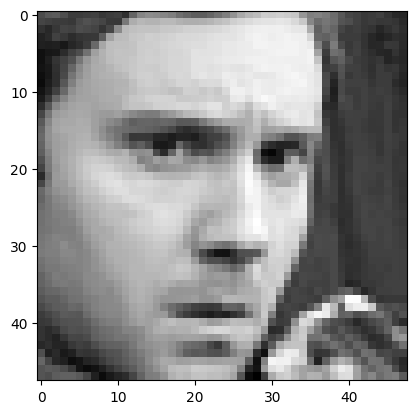

In [ ]:
# Sample images
pixels = data['pixels'][0]
pixels = np.array(pixels.split(), dtype='float32')  # Pikselleri float türüne çevir
image = pixels.reshape(48, 48)
plt.imshow(image, cmap='gray')
plt.show()


In [ ]:
train_data = data[data['Usage'] == 'Training']
validation_data = data[data['Usage'] == 'PublicTest']
test_data = data[data['Usage'] == 'PrivateTest']

In [ ]:
X_train = np.array([np.fromstring(pixels, sep=' ') for pixels in train_data['pixels']])
X_train = X_train.reshape(-1, 48, 48, 1) / 255.0  # normalization
X_train = np.repeat(X_train, 3, axis=-1)  # 1-channel to 3-channel

X_val = np.array([np.fromstring(pixels, sep=' ') for pixels in validation_data['pixels']])
X_val = X_val.reshape(-1, 48, 48, 1) / 255.0
X_val = np.repeat(X_val, 3, axis=-1)  

X_test = np.array([np.fromstring(pixels, sep=' ') for pixels in test_data['pixels']])
X_test = X_test.reshape(-1, 48, 48, 1) / 255.0
X_test = np.repeat(X_test, 3, axis=-1)  

In [ ]:
y_train = to_categorical(train_data['emotion'], num_classes=7)
y_val = to_categorical(validation_data['emotion'], num_classes=7)
y_test = to_categorical(test_data['emotion'], num_classes=7)

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)
valgen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)
datagen.fit(X_train)
valgen.fit(X_val)
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = valgen.flow(X_val, y_val, batch_size=64)

# VGG

In [ ]:
def vgg_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    for layer in base_model.layers[:-4]:  
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9, decay=0.0001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = vgg_model()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
checkpointer = [
    EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode='max', patience=10),
    ModelCheckpoint('best_model_vgg.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
]

In [ ]:
epochs = 300
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=checkpointer,
                    verbose=1)

Epoch 1/300


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728833943.600954     142 service.cc:145] XLA service 0x7f4028004f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728833943.601024     142 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  4/449 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.1185 - loss: 3.3498

I0000 00:00:1728833949.646374     142 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2310 - loss: 2.5303
Epoch 1: val_accuracy improved from -inf to 0.35414, saving model to best_model_vgg.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 81ms/step - accuracy: 0.2314 - loss: 2.5275 - val_accuracy: 0.3541 - val_loss: 1.7388
Epoch 2/300
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3573 - loss: 1.7539
Epoch 2: val_accuracy improved from 0.35414 to 0.44051, saving model to best_model_vgg.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.3574 - loss: 1.7533 - val_accuracy: 0.4405 - val_loss: 1.4749
Epoch 3/300
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4132 - loss: 1.5590
Epoch 3: val_accuracy improved from 0.44051 to 0.45528, saving model to best_model_vgg.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.4133 - loss: 1.5588 - val_accuracy: 0.4553 - val_loss: 1.4492
Epoch 4/300
446/449 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4401 - loss: 1.4870
Epoch 4: val_accuracy did n

# CNN MODEL

In [ ]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

In [ ]:
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(7, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = cnn_model()

In [ ]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
checkpointer = [EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode='max', patience=5),
                ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]

In [ ]:
epochs = 30
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=checkpointer,
                    verbose=1)

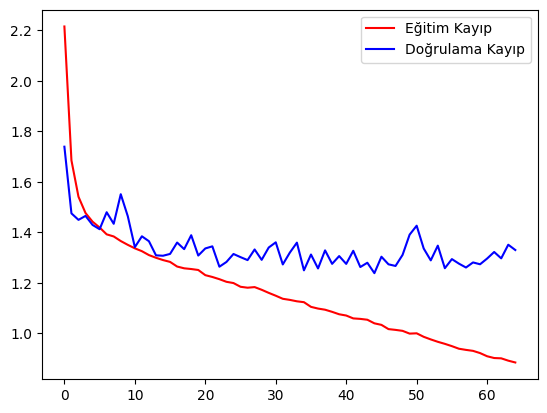

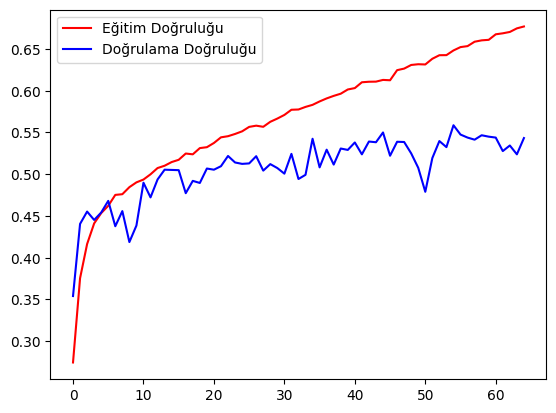

In [ ]:
plt.plot(history.history['loss'], 'r', label='Train Loss')
plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], 'r', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluating test set performance
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5745 - loss: 1.1980
Test Doğruluğu: 58.46%


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
              precision    recall  f1-score   support

           0      0.617     0.391     0.479       491
           1      0.556     0.545     0.550        55
           2      0.469     0.424     0.445       528
           3      0.725     0.808     0.764       879
           4      0.508     0.386     0.438       594
           5      0.602     0.769     0.675       416
           6      0.501     0.628     0.557       626

    accuracy                          0.585      3589
   macro avg      0.568     0.564     0.559      3589
weighted avg      0.581     0.585     0.575      3589



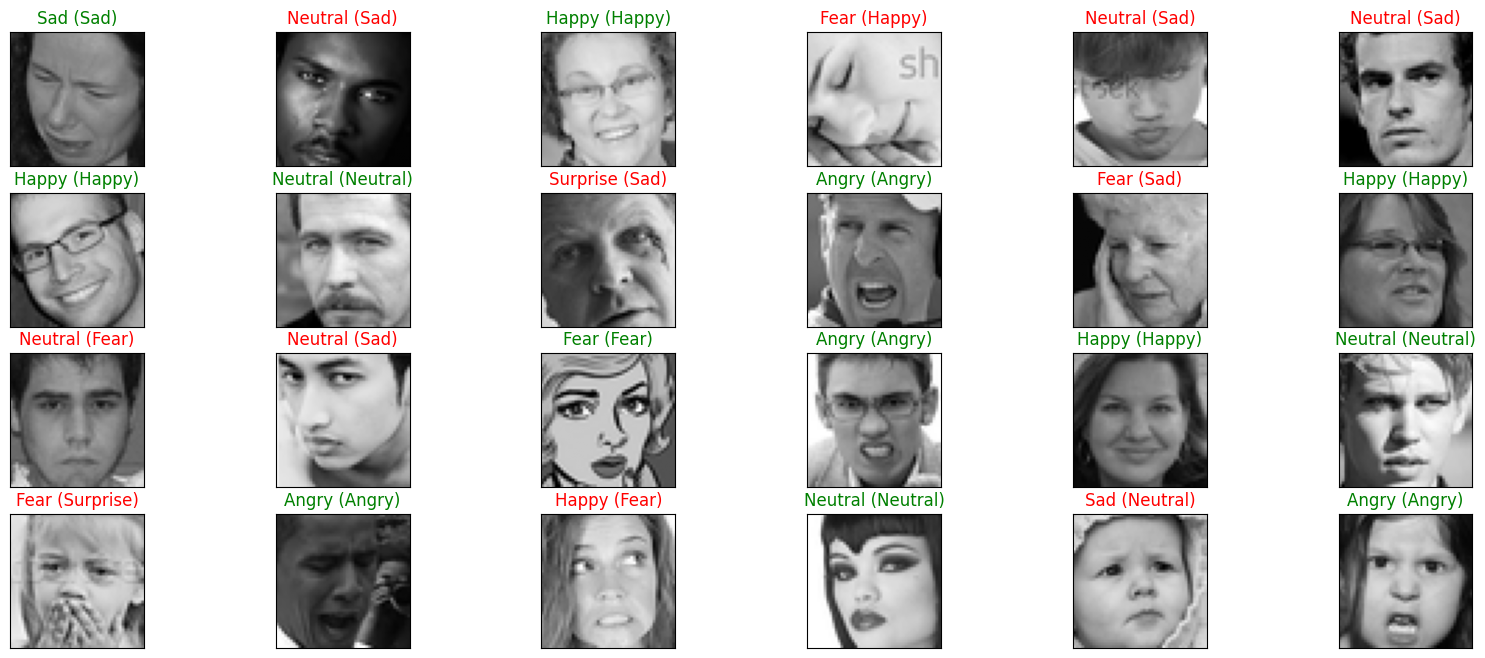

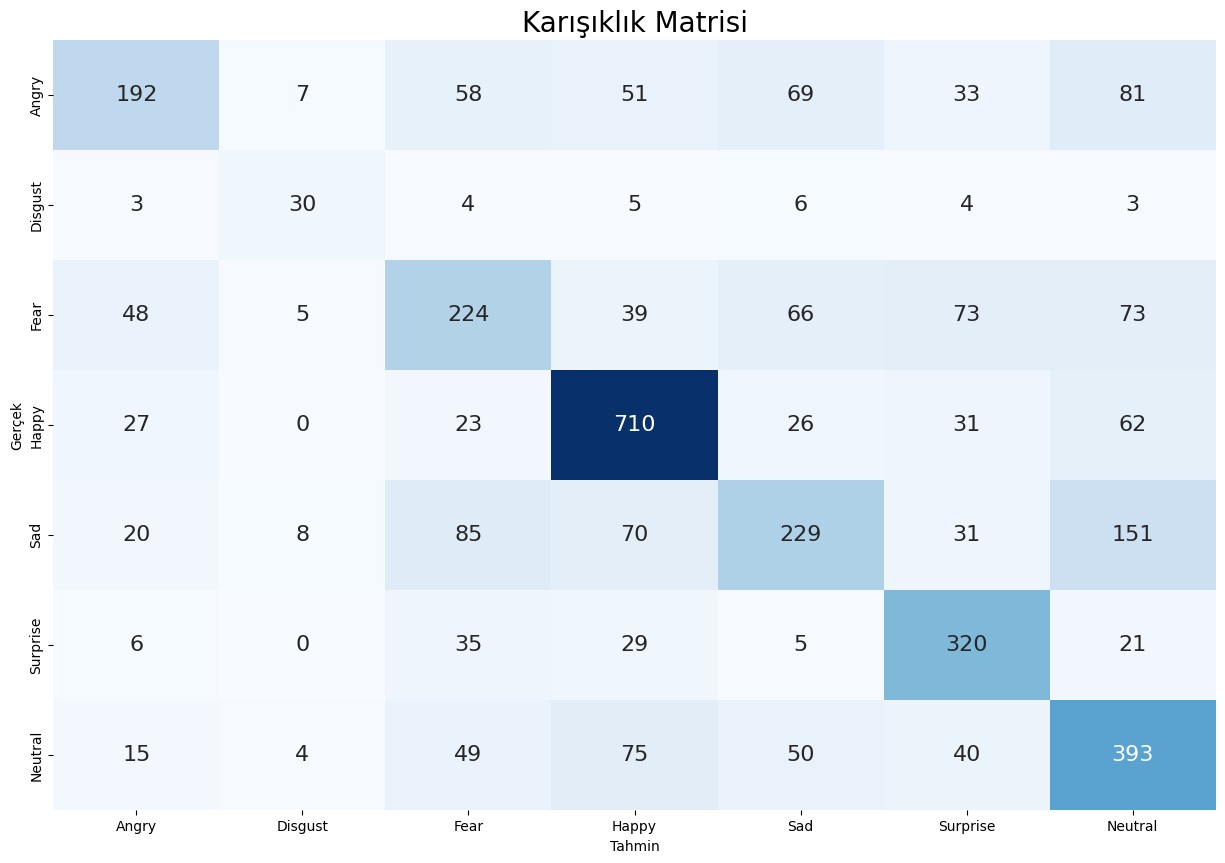

In [ ]:
# random samples from test set
y_pred = np.argmax(model.predict(X_test), axis=1)
label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = plt.subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]), cmap='gray')
    predict_index = label_dict[y_pred[index]]
    true_index = label_dict[np.argmax(y_test, axis=1)[index]]
    ax.set_title(f"{predict_index} ({true_index})", color=("green" if predict_index == true_index else "red"))

# confusion matrix and classification report
cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm_data, columns=label_dict.values(), index=label_dict.values())
cm.index.name = 'Actual'
cm.columns.name = 'Prediction'
plt.figure(figsize=(15, 10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=3))

In [19]:
model.save('best_model_vgg2.h5')